In [1]:
import pandas as pd

In [2]:
patient_registry = pd.read_csv('data/patient_registry.csv')

In [3]:
patient_registry.head()

,patient_id,age_group,risk_segment
0,P_0000,36-50,High
1,P_0001,50-65,Medium
2,P_0002,18-35,Low
3,P_0003,18-35,High
4,P_0004,50-65,Medium


In [4]:
patient_registry.info()

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   patient_id    500 non-null    str  
 1   age_group     500 non-null    str  
 2   risk_segment  500 non-null    str  
dtypes: str(3)
memory usage: 11.8 KB


In [5]:
app_logs = pd.read_json('data/app_logs.jsonl', lines=True)
app_logs_sorted = app_logs.sort_values(by='timestamp', ascending=True)

In [6]:
app_logs_sorted.head(100)

,event_id,patient_id,timestamp,event_type,payload
1956,evt_4728,P_0125,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'}
14243,evt_19020,P_0496,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'}
2174,evt_940,P_0025,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'}
1509,evt_1765,P_0047,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'}
17821,evt_608,P_0017,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'}
...,...,...,...,...,...
18390,evt_655,P_0018,2023-10-01 10:39:00,measurement_logged,{'glucose_value': 95}
15075,evt_18447,P_0481,2023-10-01 10:41:00,measurement_logged,{'glucose_value': 117}
1742,evt_11016,P_0287,2023-10-01 10:49:00,measurement_logged,{'glucose_value': 104}
15050,evt_9408,P_0245,2023-10-01 10:57:00,measurement_logged,{'glucose_value': 95}


In [7]:
app_logs_sorted.info()

<class 'pandas.DataFrame'>
Index: 19176 entries, 1956 to 3738
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_id    19176 non-null  str           
 1   patient_id  19176 non-null  str           
 2   timestamp   19176 non-null  datetime64[us]
 3   event_type  19176 non-null  str           
 4   payload     19176 non-null  object        
dtypes: datetime64[us](1), object(1), str(3)
memory usage: 898.9+ KB


In [8]:
app_logs_sorted.event_type.value_counts()

event_type
nudge_sent            13590
measurement_logged     5586
Name: count, dtype: int64

In [9]:
import pandas as pd
import json
import ast
import numpy as np

def unpack_json_column(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Desempaqueta una columna de un DataFrame que contiene diccionarios o strings con formato JSON.
    Expande las claves del JSON en nuevas columnas del DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame original.
        column_name (str): Nombre de la columna que contiene los datos JSON/dict.
        
    Returns:
        pd.DataFrame: DataFrame con las nuevas columnas agregadas.
                      Si una clave no existe en una fila, el valor será NaN.
    """
    
    def parse_item(item):
        # Si ya es un diccionario, devolverlo tal cual
        if isinstance(item, dict):
            return item
        # Si es NaN o None, devolver diccionario vacío
        if pd.isna(item):
            return {}
        # Si es string, intentar parsear
        if isinstance(item, str):
            try:
                # Intenta JSON estándar (comillas dobles)
                return json.loads(item)
            except json.JSONDecodeError:
                try:
                    # Intenta sintaxis de diccionario Python (comillas simples)
                    return ast.literal_eval(item)
                except (ValueError, SyntaxError):
                    return {}
        return {}

    # Extraer y normalizar los datos
    # Usamos tolist() porque json_normalize es mucho más rápido con listas de dicts que apply(pd.Series)
    normalized_data = pd.json_normalize(df[column_name].apply(parse_item).tolist())
    
    # Asegurar que el índice coincida con el original para la concatenación correcta
    normalized_data.index = df.index
    
    # Concatenar las nuevas columnas al DataFrame original
    return pd.concat([df, normalized_data], axis=1)

In [10]:
unpacked = unpack_json_column(app_logs_sorted, 'payload')

In [11]:
unpacked.head(10)


,event_id,patient_id,timestamp,event_type,payload,nudge_type,glucose_value
1956,evt_4728,P_0125,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN
14243,evt_19020,P_0496,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,NaN
2174,evt_940,P_0025,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN
1509,evt_1765,P_0047,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN
17821,evt_608,P_0017,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN
17862,evt_13368,P_0349,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,NaN
11209,evt_9749,P_0254,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,NaN
8190,evt_1550,P_0041,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN
3842,evt_3092,P_0082,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,NaN
17737,evt_17045,P_0444,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN


In [12]:
def add_cumulative_counts(df: pd.DataFrame, group_col: str, type_col: str, prefix: str = 'cumulative') -> pd.DataFrame:
    """
    Genera columnas de conteo acumulativo para cada categoría única en type_col.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada (debe estar ordenado cronológicamente).
        group_col (str): Columna por la cual agrupar (ej. 'patient_id').
        type_col (str): Columna categórica a contar (ej. 'nudge_type').
        prefix (str): Prefijo para las nuevas columnas generadas.
        
    Returns:
        pd.DataFrame: DataFrame original con las columnas acumulativas agregadas.
    """
    # 1. Generar columnas binarias (One-Hot) para cada tipo
    dummies = pd.get_dummies(df[type_col], prefix=prefix)
    
    # 2. Calcular suma acumulativa agrupada por el group_col (paciente)
    # Unimos temporalmente el ID del grupo para poder hacer el groupby
    cumulative = pd.concat([df[[group_col]], dummies], axis=1).groupby(group_col)[dummies.columns].cumsum()
    
    # 3. Concatenar las columnas calculadas al DataFrame original
    return pd.concat([df, cumulative], axis=1)

In [13]:
# Exploratory Data Analysis: 

df_nudges = unpacked[unpacked['event_type'] == 'nudge_sent'].drop(columns='glucose_value')

df_nudges = df_nudges.sort_values(by=['patient_id', 'timestamp'])

df_nudges = add_cumulative_counts(
    df=df_nudges, 
    group_col='patient_id', 
    type_col='nudge_type', 
    prefix='cumulative'
)

In [14]:
df_nudges['cumulative_all'] = df_nudges['cumulative_Gentle_Reminder'] + df_nudges['cumulative_Urgent_Alert']
df_nudges

,event_id,patient_id,timestamp,event_type,payload,nudge_type,cumulative_Gentle_Reminder,cumulative_Urgent_Alert,cumulative_all
4107,evt_0,P_0000,2023-10-02 11:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,1,1
17384,evt_2,P_0000,2023-10-06 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,2,2
17444,evt_4,P_0000,2023-10-07 16:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,1,2,3
7817,evt_6,P_0000,2023-10-09 15:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,2,2,4
15889,evt_8,P_0000,2023-10-11 19:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,3,2,5
...,...,...,...,...,...,...,...,...,...
5669,evt_19169,P_0499,2023-11-07 14:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,12,12,24
1012,evt_19171,P_0499,2023-11-08 15:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,13,12,25
18250,evt_19172,P_0499,2023-11-11 16:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,13,13,26
16776,evt_19174,P_0499,2023-11-12 14:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,13,14,27


In [15]:
df_nudges = df_nudges.sort_values(by='timestamp', ascending=True)
df_meas = unpacked[unpacked['event_type'] == 'measurement_logged'].drop(columns='nudge_type')
df_meas.head()

,event_id,patient_id,timestamp,event_type,payload,glucose_value
16292,evt_2559,P_0068,2023-10-01 08:19:00,measurement_logged,{'glucose_value': 83},83.0
12969,evt_13369,P_0349,2023-10-01 08:25:00,measurement_logged,{'glucose_value': 84},84.0
9735,evt_5254,P_0139,2023-10-01 08:26:00,measurement_logged,{'glucose_value': 104},104.0
13190,evt_266,P_0007,2023-10-01 08:32:00,measurement_logged,{'glucose_value': 91},91.0
12130,evt_1796,P_0048,2023-10-01 08:32:00,measurement_logged,{'glucose_value': 88},88.0


In [16]:
pd_asof = pd.merge_asof(df_meas, df_nudges, on='timestamp', by='patient_id', direction='backward', tolerance=pd.Timedelta(hours=4))

In [17]:
pd_asof[pd_asof['patient_id'] == 'P_0002']

,event_id_x,patient_id,timestamp,event_type_x,payload_x,glucose_value,event_id_y,event_type_y,payload_y,nudge_type,cumulative_Gentle_Reminder,cumulative_Urgent_Alert,cumulative_all
208,evt_72,P_0002,2023-10-02 10:52:00,measurement_logged,{'glucose_value': 94},94.0,evt_71,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0.0,1.0,1.0
532,evt_75,P_0002,2023-10-04 08:25:00,measurement_logged,{'glucose_value': 121},121.0,evt_74,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,1.0,2.0,3.0
1309,evt_79,P_0002,2023-10-08 20:03:00,measurement_logged,{'glucose_value': 92},92.0,evt_78,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,4.0,2.0,6.0
1558,evt_82,P_0002,2023-10-10 12:25:00,measurement_logged,{'glucose_value': 95},95.0,evt_81,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,5.0,3.0,8.0
3632,evt_89,P_0002,2023-10-22 18:16:00,measurement_logged,{'glucose_value': 86},86.0,evt_88,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,8.0,6.0,14.0
4281,evt_93,P_0002,2023-10-28 08:19:00,measurement_logged,{'glucose_value': 88},88.0,evt_92,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,10.0,7.0,17.0
4378,evt_95,P_0002,2023-10-29 08:29:00,measurement_logged,{'glucose_value': 103},103.0,evt_94,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,10.0,8.0,18.0
5304,evt_101,P_0002,2023-11-10 21:02:00,measurement_logged,{'glucose_value': 85},85.0,evt_100,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,14.0,9.0,23.0


In [18]:
def mark_responses(df_target: pd.DataFrame, df_source: pd.DataFrame, target_col: str = 'event_id', source_col: str = None, new_column: str = 'has_response') -> pd.DataFrame:
    """
    Marca con 1 en df_target si el valor de target_col existe en la columna source_col de df_source.
    
    Args:
        df_target (pd.DataFrame): DataFrame principal (ej. df_nudges) donde se creará la marca.
        df_source (pd.DataFrame): DataFrame de referencia (ej. pd_asof) que contiene los IDs exitosos.
        target_col (str): Nombre de la columna en df_target para hacer el match.
        source_col (str): Nombre de la columna en df_source. Si es None, se usa target_col.
        new_column (str): Nombre de la nueva columna binaria.
        
    Returns:
        pd.DataFrame: El DataFrame target con la nueva columna agregada.
    """
    if source_col is None:
        source_col = target_col
        
    # Usamos isin() que es vectorizado y eficiente para verificar pertenencia
    df_target[new_column] = df_target[target_col].isin(df_source[source_col]).astype(int)
    return df_target

In [19]:
df_final = mark_responses(df_nudges, pd_asof, target_col='event_id', source_col='event_id_y', new_column='has_response')
df_final.head()

,event_id,patient_id,timestamp,event_type,payload,nudge_type,cumulative_Gentle_Reminder,cumulative_Urgent_Alert,cumulative_all,has_response
365,evt_14410,P_0375,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,1,1,0
16033,evt_1795,P_0048,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,1,1,1
17332,evt_14929,P_0388,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,1,1,0
8190,evt_1550,P_0041,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,1,0,1,1
3632,evt_17643,P_0460,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,1,1,1


In [20]:
df_final[df_final['patient_id'] == 'P_0002']

,event_id,patient_id,timestamp,event_type,payload,nudge_type,cumulative_Gentle_Reminder,cumulative_Urgent_Alert,cumulative_all,has_response
6599,evt_71,P_0002,2023-10-02 10:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,1,1,1
14319,evt_73,P_0002,2023-10-03 17:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,1,1,2,0
15536,evt_74,P_0002,2023-10-04 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,1,2,3,1
1275,evt_76,P_0002,2023-10-05 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,2,2,4,0
4270,evt_77,P_0002,2023-10-06 09:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,3,2,5,0
8870,evt_78,P_0002,2023-10-08 17:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,4,2,6,1
4627,evt_80,P_0002,2023-10-09 14:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,5,2,7,0
7096,evt_81,P_0002,2023-10-10 12:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,5,3,8,1
3053,evt_83,P_0002,2023-10-12 10:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,5,4,9,0
5972,evt_84,P_0002,2023-10-13 20:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,5,5,10,0


In [21]:
unpacked[unpacked['patient_id'] == 'P_0002']

,event_id,patient_id,timestamp,event_type,payload,nudge_type,glucose_value
6599,evt_71,P_0002,2023-10-02 10:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,NaN
19133,evt_72,P_0002,2023-10-02 10:52:00,measurement_logged,{'glucose_value': 94},NaN,94.0
14319,evt_73,P_0002,2023-10-03 17:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN
15536,evt_74,P_0002,2023-10-04 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,NaN
1892,evt_75,P_0002,2023-10-04 08:25:00,measurement_logged,{'glucose_value': 121},NaN,121.0
1275,evt_76,P_0002,2023-10-05 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN
4270,evt_77,P_0002,2023-10-06 09:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN
8870,evt_78,P_0002,2023-10-08 17:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN
3193,evt_79,P_0002,2023-10-08 20:03:00,measurement_logged,{'glucose_value': 92},NaN,92.0
4627,evt_80,P_0002,2023-10-09 14:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,NaN


In [22]:
df_nudges[df_nudges['patient_id'] == 'P_0001']

,event_id,patient_id,timestamp,event_type,payload,nudge_type,cumulative_Gentle_Reminder,cumulative_Urgent_Alert,cumulative_all,has_response
10526,evt_35,P_0001,2023-10-01 18:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,1,0,1,0
3302,evt_36,P_0001,2023-10-04 14:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,1,1,2,1
6514,evt_38,P_0001,2023-10-05 16:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,1,2,3,0
2369,evt_39,P_0001,2023-10-06 18:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,2,2,4,1
4413,evt_41,P_0001,2023-10-09 16:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,3,2,5,0
926,evt_42,P_0001,2023-10-12 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,3,3,6,1
3252,evt_44,P_0001,2023-10-13 11:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,3,4,7,1
16415,evt_46,P_0001,2023-10-16 09:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,3,5,8,0
142,evt_47,P_0001,2023-10-17 10:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,4,5,9,0
2618,evt_48,P_0001,2023-10-19 11:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,4,6,10,0


In [23]:
df_nudges = df_nudges.merge(patient_registry, left_on='patient_id', right_on='patient_id')

In [40]:
df_gentle = df_nudges[df_nudges['nudge_type'] == 'Gentle_Reminder']
df_gentle.groupby(by=['cumulative_Gentle_Reminder', 'age_group', 'risk_segment'])[['has_response']].mean()

has_response
cumulative_Gentle_Reminder age_group risk_segment              
1                          18-35     High              0.911765
                                     Low               0.404255
                                     Medium            0.460000
                           36-50     High              0.666667
                                     Low               0.540984
...                                                         ...
21                         65+       High              0.000000
22                         18-35     High              1.000000
                           50-65     High              0.000000
23                         18-35     High              0.000000
                           50-65     High              0.000000

[247 rows x 1 columns]

In [39]:
df_urgent = df_nudges[df_nudges['nudge_type'] == 'Urgent_Alert']
df_urgent.groupby(by=['cumulative_Urgent_Alert', 'age_group', 'risk_segment'])[['has_response']].mean()

has_response
cumulative_Urgent_Alert age_group risk_segment              
1                       18-35     High              0.794118
                                  Low               0.553191
                                  Medium            0.540000
                        36-50     High              0.888889
                                  Low               0.491803
...                                                      ...
21                      36-50     Low               0.500000
                        50-65     Medium            0.000000
22                      50-65     Medium            0.000000
23                      50-65     Medium            0.000000
24                      50-65     Medium            0.000000

[243 rows x 1 columns]

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


def wilson_ci(n_success, n_total, confidence=0.95):
    if n_total == 0:
        return np.nan, np.nan
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    p_hat = n_success / n_total
    denom = 1 + z**2 / n_total
    center = (p_hat + z**2 / (2 * n_total)) / denom
    margin = (z * np.sqrt(p_hat * (1 - p_hat) / n_total + z**2 / (4 * n_total**2))) / denom
    return center - margin, center + margin


def compute_global_ci(sub, cum_col, max_nudge=30):
    result = {}
    for nudge_n in range(1, max_nudge + 1):
        grp = sub[sub[cum_col] == nudge_n]["has_response"]
        n = len(grp)
        if n == 0:
            continue
        lo, hi = wilson_ci(grp.sum(), n)
        result[nudge_n] = {"n": n, "lower": lo, "upper": hi, "rate": grp.sum() / n}
    return result


def compute_group_rates(sub, cum_col, group_col, max_nudge=30):
    results = {}
    for group_val, gdf in sub.groupby(group_col):
        positions, rates = [], []
        for nudge_n in range(1, max_nudge + 1):
            grp = gdf[gdf[cum_col] == nudge_n]["has_response"]
            if len(grp) == 0:
                continue
            positions.append(nudge_n)
            rates.append(grp.sum() / len(grp))
        results[group_val] = {
            "positions": np.array(positions),
            "rates": np.array(rates),
        }
    return results


PALETTES = {
    "default": [
        "#4fc3f7", "#81c784", "#ffb74d", "#f06292",
        "#ba68c8", "#4db6ac", "#ff8a65", "#90a4ae"
    ]
}

NUDGE_CONFIGS = [
    {
        "subset_val": "Gentle_Reminder",
        "cum_col": "cumulative_Gentle_Reminder",
        "title": "Gentle Reminder",
        "panel_color": "#4fc3f7",
    },
    {
        "subset_val": "Urgent_Alert",
        "cum_col": "cumulative_Urgent_Alert",
        "title": "Urgent Alert",
        "panel_color": "#ff7043",
    },
]


def plot_nudge_response(
    df,
    group_col=None,          # None → gráfica global sin subgrupos
    palette=None,            # Lista de colores personalizada (opcional)
    fig_title=None,          # Título de la figura (opcional)
    filename=None,           # Ruta para guardar (opcional, si None solo muestra)
    max_nudge=30,
    confidence=0.95,
):
    """
    Visualiza la tasa de respuesta (has_response) por nudge acumulado.

    Parámetros
    ----------
    df         : DataFrame con columnas nudge_type, cumulative__Gentle_Reminder,
                 cumulative__Urgent_Alert, has_response y opcionalmente group_col.
    group_col  : Columna de segmentación (ej. 'age_group', 'risk_segment').
                 Si es None, genera la gráfica global sin subgrupos.
    palette    : Lista de colores hex para los subgrupos. Si es None usa la paleta default.
    fig_title  : Título de la figura. Si es None se genera automáticamente.
    filename   : Ruta del archivo de salida (.png). Si es None solo muestra la figura.
    max_nudge  : Número máximo de nudges acumulados a mostrar (default 30).
    confidence : Nivel de confianza para el IC de Wilson (default 0.95).
    """

    palette = palette or PALETTES["default"]

    # Título automático si no se provee
    if fig_title is None:
        if group_col:
            fig_title = f"Tasa de respuesta por {group_col} y nudge acumulado"
        else:
            fig_title = "Tasa de respuesta global por nudge acumulado"

    fig, axes = plt.subplots(1, 2, figsize=(22, 8), facecolor="#0d0d0d")
    fig.suptitle(fig_title, fontsize=15, color="white", fontweight="bold", y=1.01)

    for cfg, ax in zip(NUDGE_CONFIGS, axes):
        sub = df[df["nudge_type"] == cfg["subset_val"]].copy()
        global_ci = compute_global_ci(sub, cfg["cum_col"], max_nudge)

        ci_positions = np.array(list(global_ci.keys()))
        ci_lower     = np.array([v["lower"] for v in global_ci.values()])
        ci_upper     = np.array([v["upper"] for v in global_ci.values()])
        global_rates = np.array([v["rate"]  for v in global_ci.values()])
        ns           = np.array([v["n"]     for v in global_ci.values()])

        ax.set_facecolor("#1a1a1a")

        # ── Banda IC global (siempre presente) ──
        ax.fill_between(ci_positions, ci_lower, ci_upper,
                        alpha=0.15, color="white", label="IC 95% global (Wilson)")

        if group_col:
            # ── Modo subgrupos: línea por categoría ──
            group_rates = compute_group_rates(sub, cfg["cum_col"], group_col, max_nudge)
            for i, (group_val, data) in enumerate(sorted(group_rates.items())):
                color = palette[i % len(palette)]
                ax.plot(data["positions"], data["rates"],
                        color=color, linewidth=2,
                        marker="o", markersize=4, label=str(group_val))
        else:
            # ── Modo global: línea de tasa total ──
            ax.plot(ci_positions, global_rates,
                    color=cfg["panel_color"], linewidth=2.5,
                    marker="o", markersize=5, label="Tasa global")

        # Referencia 50%
        ax.axhline(0.5, color="#555555", linestyle="--", linewidth=1, label="50%")

        # ── N en eje secundario ──
        ax2 = ax.twinx()
        bar_color = palette[0] if group_col else cfg["panel_color"]
        ax2.bar(ci_positions, ns, color=bar_color, alpha=0.12, width=0.6, label="n total")
        ax2.set_ylabel("n observaciones (total)", color="#888888", fontsize=10)
        ax2.tick_params(colors="#888888")
        ax2.spines[:].set_color("#333333")
        ax2.set_ylim(0, ns.max() * 4)

        # ── Estética ──
        ax.set_xlim(0.5, max_nudge + 0.5)
        ax.set_ylim(-0.05, 1.05)
        ax.set_xticks(range(1, max_nudge + 1))
        ax.set_xticklabels(range(1, max_nudge + 1), fontsize=8, color="#cccccc", rotation=45)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.set_yticklabels([f"{v:.0%}" for v in np.arange(0, 1.1, 0.1)], fontsize=9, color="#cccccc")
        ax.set_xlabel("Nudges acumulados", color="#aaaaaa", fontsize=11)
        ax.set_ylabel("Tasa de respuesta", color="#aaaaaa", fontsize=11)
        ax.set_title(cfg["title"], color=cfg["panel_color"], fontsize=14, fontweight="bold", pad=10)
        ax.tick_params(colors="#cccccc")
        ax.spines[:].set_color("#333333")
        ax.grid(axis="y", color="#2a2a2a", linestyle="--", linewidth=0.7)
        ax.grid(axis="x", color="#2a2a2a", linestyle=":", linewidth=0.5)

        legend_title = group_col if group_col else None
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2,
                  facecolor="#222222", edgecolor="#444444",
                  labelcolor="white", fontsize=9,
                  loc="upper right", title=legend_title, title_fontsize=9)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150, bbox_inches="tight", facecolor="#0d0d0d")
        print(f"Guardado: {filename}")
    plt.show()

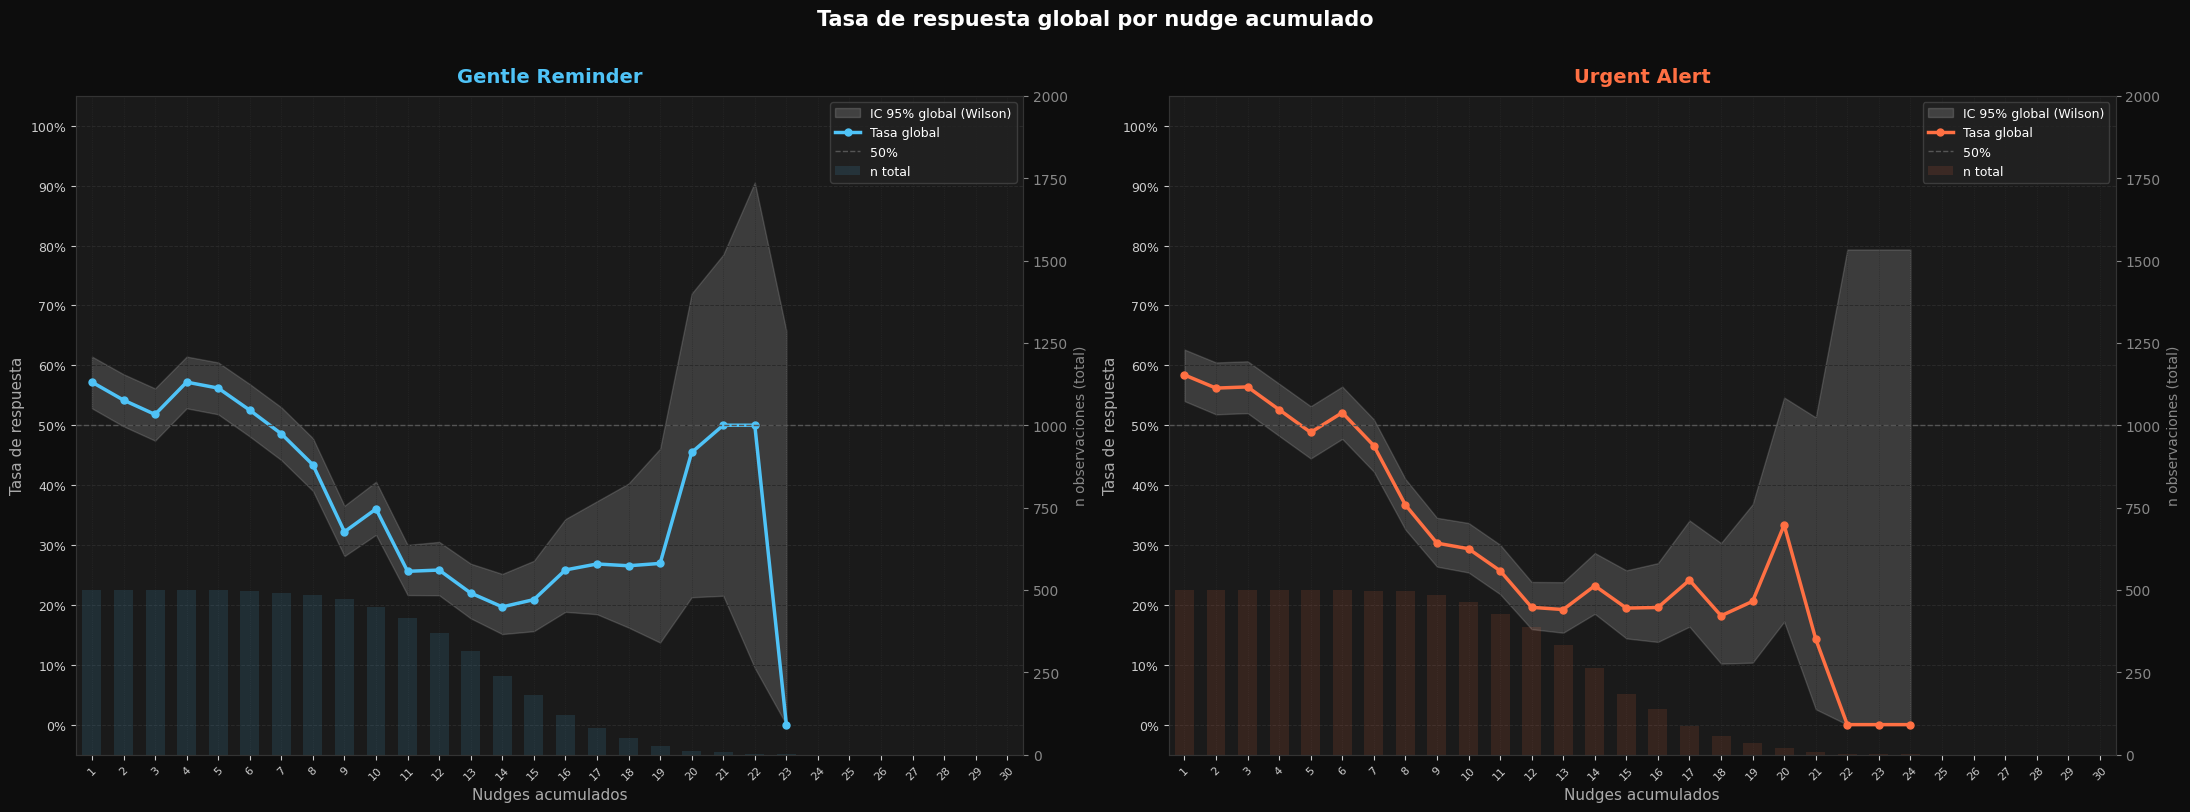

In [27]:
plot_nudge_response(df_nudges)


Guardado: response_age_group.png


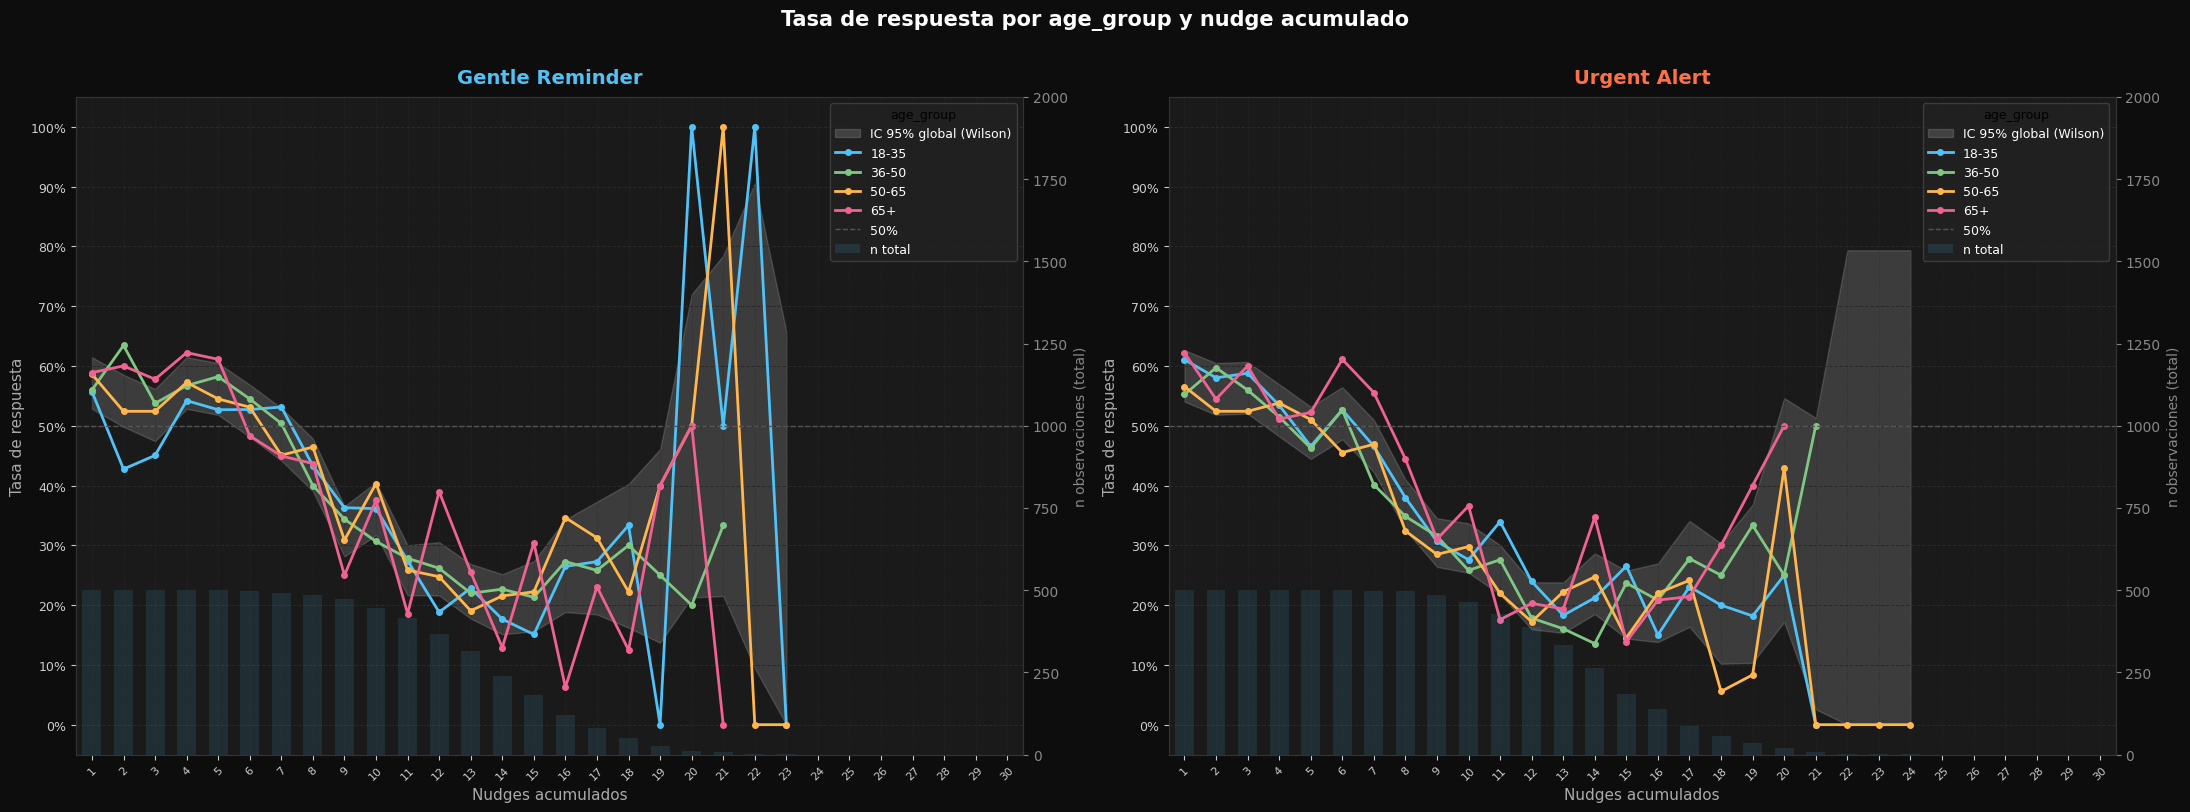

In [28]:
# Figura 1: por Age Group
plot_nudge_response(df_nudges, group_col="age_group", filename="response_age_group.png")


Guardado: response_risk_segment.png


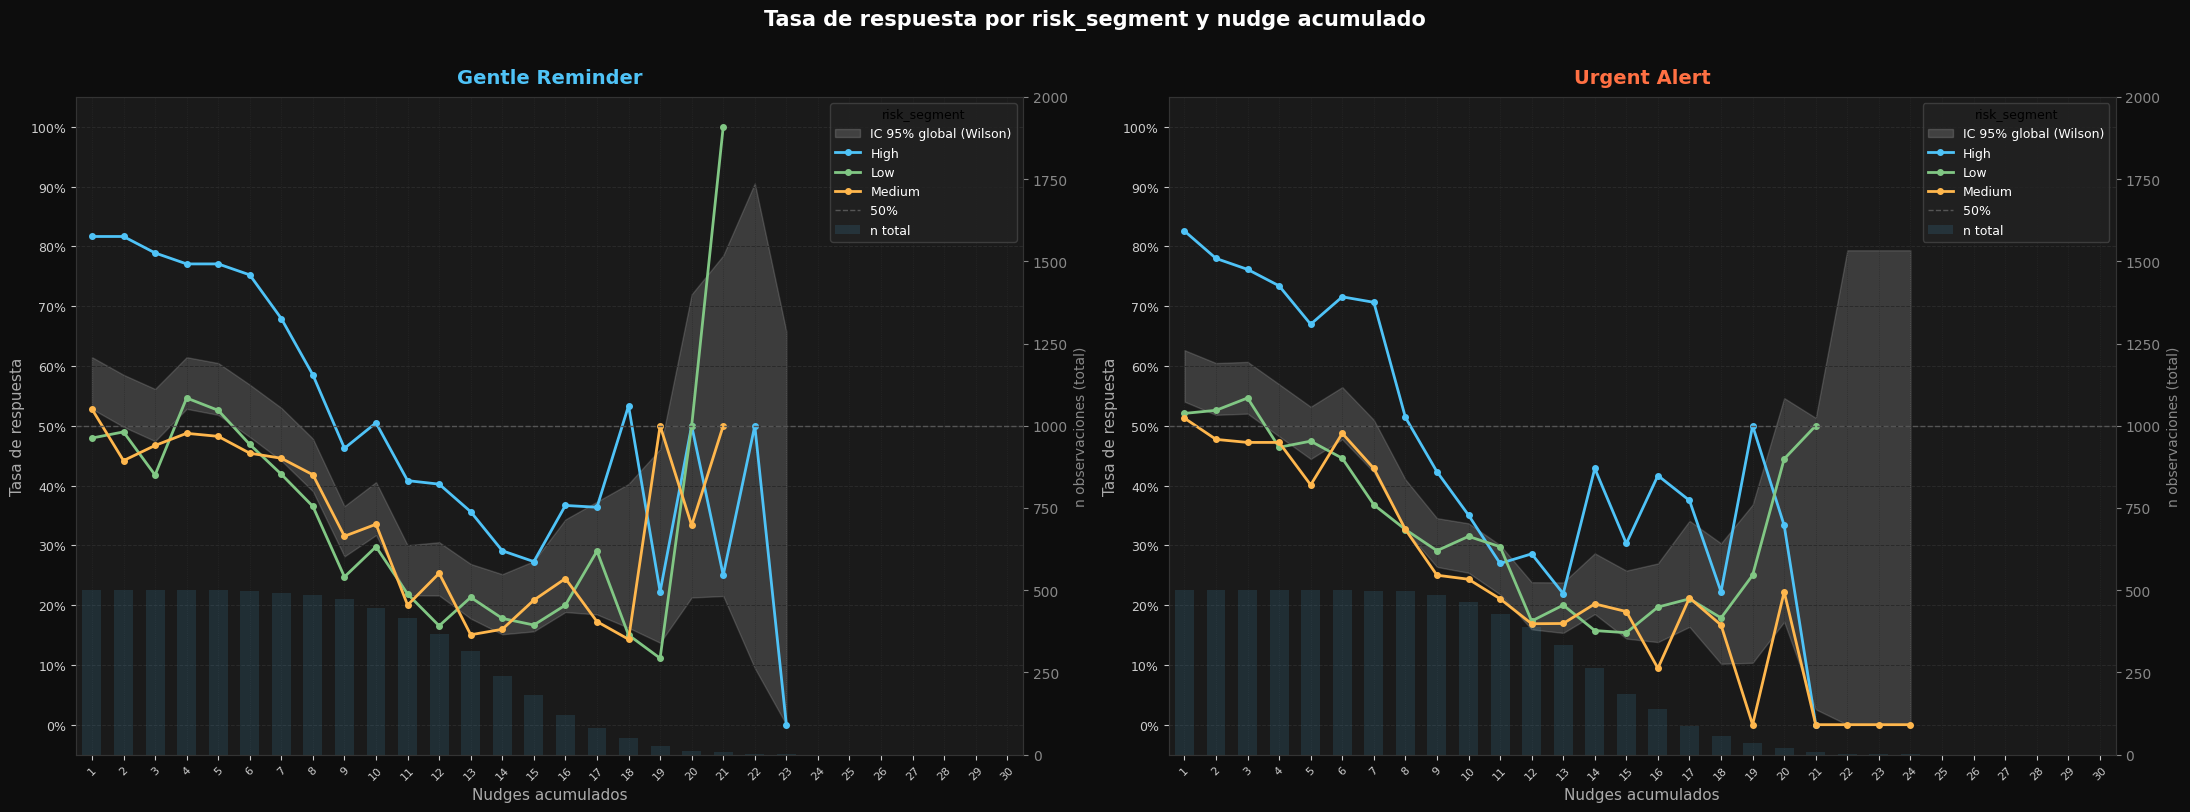

In [29]:
plot_nudge_response(df_nudges, group_col="risk_segment", filename="response_risk_segment.png")


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# 1. Define control parameters
MIN_OBSERVATIONS = 30  # Standard threshold for rely on Chi-Square
max_nudge_to_evaluate = 30  # High limit, the code will stop itself based on the threshold

print(f"Searching for the breakpoint vs. Nudge 1 (Threshold: Min {MIN_OBSERVATIONS} patients per nudge)\n")
print("=" * 65)

# Iterate from nudge 2 onwards
for i in range(2, max_nudge_to_evaluate + 1):
    
    # 2. Calculate how many people received this specific Nudge
    n_observations_i = len(df_nudges[df_nudges['cumulative_all'] == i])
    
    # 3. The Stop Rule: If it falls below the threshold, halt the analysis
    if n_observations_i < MIN_OBSERVATIONS:
        print(f"\n🛑 ANALYSIS STOPPED AT NUDGE {i}")
        print(f"   Reason: Only {n_observations_i} observations remaining (Below the threshold of {MIN_OBSERVATIONS}).")
        print("   From here on, the risk of false positives/negatives is too high.")
        break # Breaks the loop to avoid unnecessary or statistically weak calculations
        
    # 4. If there's enough data, proceed with the usual filtering
    df_filtered = df_nudges[df_nudges['cumulative_all'].isin([1, i])]
    
    # Create the contingency table
    table = pd.crosstab(df_filtered['cumulative_all'], df_filtered['has_response'])
    
    # Validate that we have a 2x2 matrix
    if table.shape == (2, 2):
        chi2, p_value, dof, expected = chi2_contingency(table)
        
        # Calculate response rates (%) for business context
        rate_nudge_1 = (table.loc[1, 1] / table.loc[1].sum()) * 100
        rate_nudge_i = (table.loc[i, 1] / table.loc[i].sum()) * 100
        
        # Format the conclusion
        if p_value < 0.05:
            result = "🚨 YES (Significant difference)"
        else:
            result = "No (No significant difference)"
            
        # Print results adding the N of the evaluated nudge
        print(f"Comparing Nudge 1 vs Nudge {i} (Available sample N={n_observations_i})")
        print(f"  - Response Rate: Nudge 1 ({rate_nudge_1:.1f}%) vs Nudge {i} ({rate_nudge_i:.1f}%)")
        print(f"  - P-value: {p_value:.4f} -> {result}")
        print("-" * 65)

Searching for the breakpoint vs. Nudge 1 (Threshold: Min 30 patients per nudge)

Comparing Nudge 1 vs Nudge 2 (Available sample N=500)
  - Response Rate: Nudge 1 (60.8%) vs Nudge 2 (55.2%)
  - P-value: 0.0836 -> No (No significant difference)
-----------------------------------------------------------------
Comparing Nudge 1 vs Nudge 3 (Available sample N=500)
  - Response Rate: Nudge 1 (60.8%) vs Nudge 3 (54.4%)
  - P-value: 0.0473 -> 🚨 YES (Significant difference)
-----------------------------------------------------------------
Comparing Nudge 1 vs Nudge 4 (Available sample N=500)
  - Response Rate: Nudge 1 (60.8%) vs Nudge 4 (56.2%)
  - P-value: 0.1580 -> No (No significant difference)
-----------------------------------------------------------------
Comparing Nudge 1 vs Nudge 5 (Available sample N=500)
  - Response Rate: Nudge 1 (60.8%) vs Nudge 5 (54.6%)
  - P-value: 0.0548 -> No (No significant difference)
-----------------------------------------------------------------
Compari

In [51]:
df_nudges[(df_nudges['cumulative_all']==30) & (df_nudges['nudge_type'] == 'Gentle_Reminder')]

,event_id,patient_id,timestamp,event_type,payload,nudge_type,cumulative_Gentle_Reminder,cumulative_Urgent_Alert,cumulative_all,has_response,age_group,risk_segment,is_after_10
10708,evt_12664,P_0329,2023-11-05 12:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,14,16,30,0,50-65,Medium,False
10995,evt_724,P_0019,2023-11-06 12:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,12,18,30,1,50-65,Medium,False
11043,evt_215,P_0005,2023-11-06 14:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,13,17,30,0,18-35,High,False
11220,evt_9597,P_0249,2023-11-07 09:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,13,17,30,0,65+,High,False
11296,evt_7720,P_0201,2023-11-07 13:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,17,13,30,1,50-65,High,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13533,evt_17044,P_0443,2023-11-14 18:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,14,16,30,0,50-65,Low,False
13540,evt_16171,P_0420,2023-11-14 18:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,13,17,30,0,18-35,Medium,False
13542,evt_8444,P_0220,2023-11-14 18:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,15,15,30,0,18-35,High,False
13547,evt_18756,P_0488,2023-11-14 19:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,12,18,30,1,50-65,Low,False


In [52]:
df_nudges

,event_id,patient_id,timestamp,event_type,payload,nudge_type,cumulative_Gentle_Reminder,cumulative_Urgent_Alert,cumulative_all,has_response,age_group,risk_segment,is_after_10
0,evt_14410,P_0375,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,1,1,0,18-35,High,True
1,evt_1795,P_0048,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,1,1,1,50-65,Medium,True
2,evt_14929,P_0388,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,1,1,0,36-50,Medium,True
3,evt_1550,P_0041,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,1,0,1,1,36-50,Low,True
4,evt_17643,P_0460,2023-10-01 08:00:00,nudge_sent,{'nudge_type': 'Urgent_Alert'},Urgent_Alert,0,1,1,1,65+,Medium,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,evt_4869,P_0128,2023-11-14 20:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,12,12,24,1,65+,Medium,False
13586,evt_17259,P_0449,2023-11-14 20:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,13,9,22,0,18-35,Low,False
13587,evt_11509,P_0298,2023-11-14 20:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,11,16,27,0,50-65,Low,False
13588,evt_12843,P_0334,2023-11-14 20:00:00,nudge_sent,{'nudge_type': 'Gentle_Reminder'},Gentle_Reminder,13,16,29,0,18-35,Low,False
